# <center> Text clusterization with LDA

## Import data

In [291]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
import razdel
import pymorphy2
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from razdel import tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

## Load articles dataset

In [2]:
text_dataset_name = "materials.csv"

text_df = pd.read_csv(text_dataset_name)

In [3]:
# show common info

text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   doc_id  27000 non-null  int64 
 1   title   27000 non-null  object
dtypes: int64(1), object(1)
memory usage: 422.0+ KB


In [4]:
text_df.head(3)

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


## Prepare dataset

In [5]:
# download stopwords
# nltk.download()
stopwords_ru = stopwords.words("russian")

In [6]:
len(stopwords_ru)

151

In [7]:
# add new stopwords
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopwords_ru += additional_stopwords
len(stopwords_ru)

776

In [8]:
# get morph

morph = pymorphy2.MorphAnalyzer()

In [13]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", " ", text)
    
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopwords_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
titles = text_df["title"]
titles = titles.apply(lambda x: clean_text(x)) # clean texts
voc = titles.apply(lambda x: lemmatization(x))# get lem words

In [15]:
voc = voc.to_numpy()

In [54]:
common_voc = Dictionary(voc)
common_corpus = [common_voc.doc2bow(words) for words in voc]

In [57]:
# train lda model
topics = 25
lda = LdaModel(common_corpus, num_topics=topics, id2word=common_voc)

In [58]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год тыс рынок составить это который млн
topic_1: японский китайский япония кость доставить больница зуб
topic_2: фонд снижение испытание характерный полоса предупредить внедрение
topic_3: кровь воздух фотография граница компания производить оплата
topic_4: погибнуть журнал восток писать пилот лётчик память
topic_5: год млрд рубль это млн рост который
topic_6: ракета экипаж фильм год флот приговор норвежский
topic_7: научный школа вуз ступень который физика великий
topic_8: фестиваль египет пройти мероприятие тур гость организатор
topic_9: который человек год это время свой весь
topic_10: это год россия который страна президент свой
topic_11: который год суд статья дело исследование это
topic_12: женщина мужчина бомба захватить золото пляж задать
topic_13: украина украинский киев квартира инвестиция убийство рада
topic_14: это россия российский который мочь вопрос новый
topic_15: это исследование ребёнок который гражданин риск система
topic_16: военный армия объект наука пациен

In [83]:
def text_topics(text, show_info=False):
    lem_words = lemmatization(text)
    text_corpus = common_voc.doc2bow(lem_words)
    lda_info = lda[text_corpus]
    if show_info:
        print(lda_info, text, sep="\n")
    return lda_info

In [116]:
text = text_df.iloc[2][1]
text_topics(text=text, show_info=True)

[(0, 0.19151142), (6, 0.017292067), (7, 0.17847282), (8, 0.23310882), (12, 0.031062555), (18, 0.039589655), (20, 0.03199277), (22, 0.26147017)]
Форвард «Авангарда» Томаш Заборский прокомментировал игру своей команды в матче чемпионата КХЛ против «Атланта»n(4:3)n.nn«Мы провели плохой матч в Нижнем Новгороде против «Торпедо» и настраивались, что с первых же минут включимся в работу, — сказал Заборский. — У нас получилось забросить быстрый гол и задать хороший темп поединку. Мы можем играть еще лучше, но, с другой стороны, пять очков на выезде из девяти — это лучше, чем ничего».


[(0, 0.19151142),
 (6, 0.017292067),
 (7, 0.17847282),
 (8, 0.23310882),
 (12, 0.031062555),
 (18, 0.039589655),
 (20, 0.03199277),
 (22, 0.26147017)]

## Transform data to DataFrame

In [110]:
def get_lda_matrix(texts, num_topics):
    lda_matrix = np.zeros(shape=(len(texts), num_topics))
    for i, text in enumerate(texts):
        lda_info = text_topics(text, show_info=False)
        for topic, proba in lda_info:
            lda_matrix[i,topic] = proba 
                          
    return lda_matrix

In [111]:
lda_matrix = get_lda_matrix(text_df["title"].values, num_topics=topics)

In [113]:
transform_df = pd.DataFrame(lda_matrix, columns = [f"topic_{i}" for i in range(topics)])
transform_df['doc_id'] = text_df['doc_id']

In [114]:
transform_df.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,doc_id
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.093944,0.050322,0.000000,...,0.0,0.000000,0.00000,0.00000,0.257699,0.0,0.000000,0.000000,0.0,6
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.289812,0.564984,...,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,4896
2,0.191441,0.000000,0.0,0.0,0.0,0.0,0.017142,0.178433,0.233101,0.000000,...,0.0,0.000000,0.03959,0.00000,0.031989,0.0,0.261743,0.000000,0.0,4897
3,0.087504,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.102924,0.000000,...,0.0,0.354813,0.00000,0.09069,0.000000,0.0,0.190381,0.022616,0.0,4898
4,0.000000,0.414683,0.0,0.0,0.0,0.0,0.000000,0.141772,0.000000,0.000000,...,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,4899


## Get users data

In [117]:
users_filename = "users_articles.csv"

users_df = pd.read_csv(users_filename)

In [118]:
users_df.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [274]:
def get_users_matrix(articles, metric="mean"):
    user_vectors = []
    for article in articles:
        articles_id = map(int, article[1:-1].split(","))
        transform_data = transform_df[transform_df["doc_id"].isin(articles_id)].drop(columns=["doc_id"]).to_numpy()
        if metric == "mean":
            user_vector = transform_data.mean(axis=0)
        elif metric == "median":
            user_vector = np.median(transform_data, axis=0)
        else:
            user_vector = transform_data.max(axis=0)
        
        user_vectors.append(user_vector)
        
    return np.asarray(user_vectors)

In [271]:
def get_users_transform_data(metric="mean"):
    users_articles = users_df["articles"].values
    users_matrix = get_users_matrix(users_articles, metric=metric)
    users_transform_data = pd.DataFrame(users_matrix, columns=[f"topic_{i}" for i in range(topics)])
    users_transform_data["uid"] = users_df["uid"]
    
    return users_transform_data

In [272]:
users_transform_data = get_users_transform_data(metric="mean")

In [248]:
users_transform_data.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,uid
0,0.018743,0.000000,0.000000,0.006813,0.005054,0.114209,0.012401,0.066106,0.000000,0.215874,...,0.011077,0.000000,0.000000,0.000000,0.020070,0.000000,0.010055,0.008894,0.000000,u105138
1,0.029246,0.000000,0.000000,0.000000,0.002343,0.061114,0.003520,0.000000,0.000000,0.189149,...,0.009204,0.013630,0.008049,0.016280,0.016384,0.000000,0.049484,0.004235,0.000000,u108690
2,0.009968,0.034698,0.002773,0.003951,0.010047,0.051074,0.000000,0.029917,0.002513,0.327895,...,0.018467,0.016265,0.000000,0.004833,0.040271,0.000000,0.008365,0.000000,0.000000,u108339
3,0.025175,0.000000,0.009386,0.000000,0.093386,0.003910,0.002140,0.051771,0.129506,0.117239,...,0.000000,0.001843,0.011662,0.022927,0.003399,0.028164,0.259013,0.000000,0.011353,u101138
4,0.052971,0.005204,0.000000,0.010944,0.002599,0.022135,0.000000,0.030747,0.003609,0.256263,...,0.005604,0.000000,0.002381,0.040187,0.022435,0.000000,0.056773,0.002450,0.008185,u108248


## Train target model

### Prepare train/test data

In [260]:
def get_train_test_data(users_data, test_split=0.33, random_state=42):
    target = pd.read_csv("users_churn.csv")
    
    X = pd.merge(users_data, target, 'left')
    
    x_colummns = [f"topic_{i}" for i in range(topics)]
    target_col = ["churn"]

    X_target = X[x_colummns]
    y = X[target_col]
    
    train_X, test_X, train_Y, test_Y = train_test_split(X_target, y, test_size=test_split, random_state=random_state)
    
    return train_X, test_X, train_Y, test_Y

In [261]:
train_X, test_X, train_Y, test_Y = get_train_test_data(users_transform_data)

### Train model

In [262]:
model = LogisticRegression()
model.fit(train_X, train_Y)

d:\pycharmprojects\bisnessml\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [263]:
preds = model.predict_proba(test_X)[:, 1]
preds[:10]

array([0.00118387, 0.09086066, 0.01576283, 0.07268368, 0.1885132 ,
       0.03662875, 0.00999971, 0.11186067, 0.38153896, 0.04506953])

### Рассчитаем Precision, Recall, F_score

In [264]:
class PRF_score:
    
    def __init__(self, model, test_X, test_Y):
        self.preds = model.predict_proba(test_X)[:,1]
        self.test_X, self.test_Y = test_X, test_Y
        self.fscore = None
        self.precision = None
        self.recall = None
        self.thresholds = None
        self.ix = 0
    
    def get_prt(self):
        self.precision, self.recall, self.thresholds = precision_recall_curve(test_Y, preds)
        self.fscore = (2 * self.precision * self.recall) / (self.precision + self.recall)
        # locate the index of the largest f score
        self.ix = np.argmax(self.fscore)
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (self.thresholds[self.ix], 
                                                                                self.fscore[self.ix],
                                                                                self.precision[self.ix],
                                                                                self.recall[self.ix]))
    @staticmethod
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
    def start(self):
        self.get_prt()
        
        font = {'size' : 15}

        plt.rc('font', **font)

        cnf_matrix = confusion_matrix(self.test_Y, self.preds>self.thresholds[self.ix])
        plt.figure(figsize=(10, 8))
        self.plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                                  title='Confusion matrix')
        plt.savefig("conf_matrix.png")
        plt.show()
        
        print(f"roc_auc_score = {roc_auc_score(self.test_Y, self.preds)}")
        
        
        

Best Threshold=0.273322, F-Score=0.656, Precision=0.618, Recall=0.699
Confusion matrix, without normalization
[[2159  145]
 [ 102  234]]


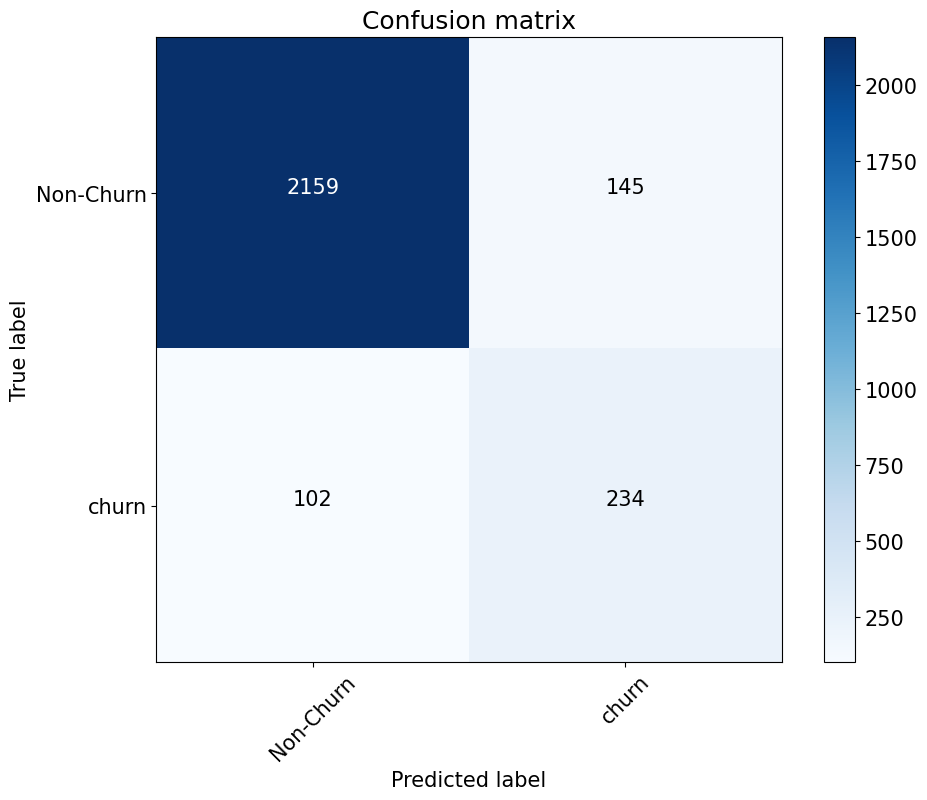

roc_auc_score = 0.9374496217757935


In [265]:
prf = PRF_score(model=model, test_X=test_X, test_Y=test_Y)
prf.start()

# Other tasks

## Task 2

### change mean to median

In [275]:
median_users_td = get_users_transform_data(metric="median")

In [276]:
train_X, test_X, train_Y, test_Y = get_train_test_data(median_users_td)

In [277]:
model_median = LogisticRegression()
model_median.fit(train_X, train_Y)

d:\pycharmprojects\bisnessml\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [278]:
preds = model_median.predict_proba(test_X)[:, 1]
preds[:10]

array([0.00280045, 0.04276557, 0.02879624, 0.01408472, 0.24368406,
       0.13067769, 0.01381709, 0.15834879, 0.5195974 , 0.04819645])

Best Threshold=0.262259, F-Score=0.709, Precision=0.643, Recall=0.789
Confusion matrix, without normalization
[[2157  147]
 [  72  264]]


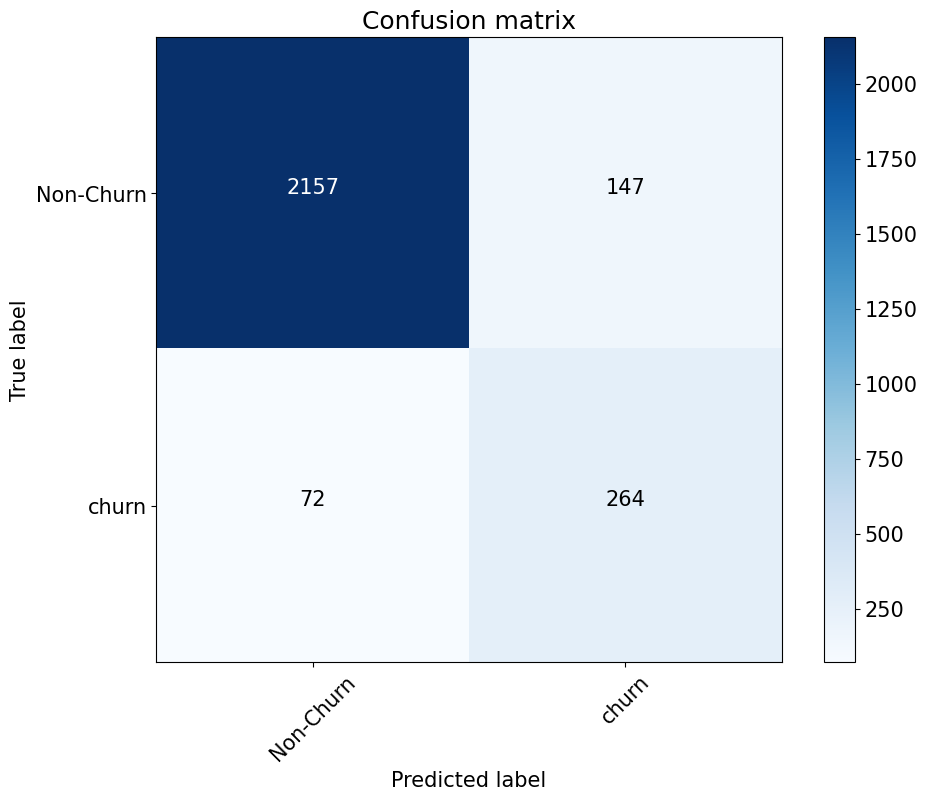

roc_auc_score = 0.9504071593915343


In [279]:
prf_median = PRF_score(model=model_median, test_X=test_X, test_Y=test_Y)
prf_median.start()

## Task 3

### change metric to max

In [280]:
max_users_td = get_users_transform_data(metric="max")

In [281]:
train_X, test_X, train_Y, test_Y = get_train_test_data(max_users_td)

In [282]:
model_max = LogisticRegression()
model_max.fit(train_X, train_Y)

d:\pycharmprojects\bisnessml\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [283]:
preds = model_median.predict_proba(test_X)[:, 1]
preds[:10]

array([0.08402946, 0.99759275, 0.52852255, 0.99993111, 0.9988596 ,
       0.90848904, 0.8133042 , 0.9971428 , 0.99737467, 0.95831306])

d:\pycharmprojects\bisnessml\venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Best Threshold=0.999965, F-Score=nan, Precision=0.000, Recall=0.000
Confusion matrix, without normalization
[[2304    0]
 [ 336    0]]


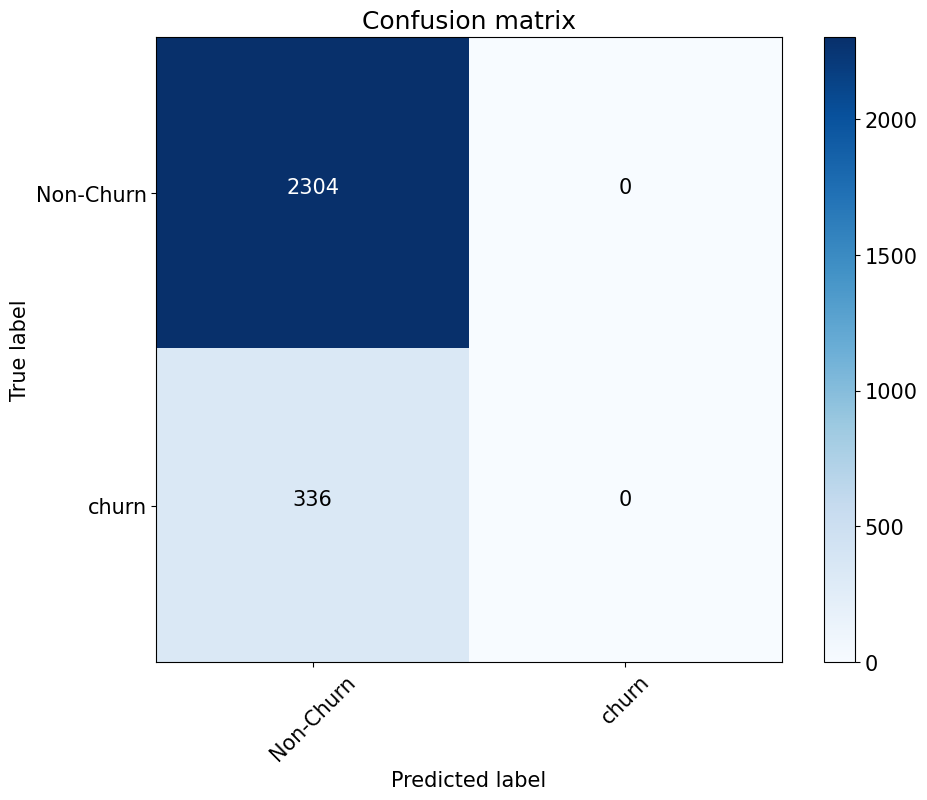

roc_auc_score = 0.9685717385912698


In [284]:
prf_max = PRF_score(model_max, test_X, test_Y)
prf_max.start()

## Task 4

### add idf

In [286]:
# need to find idf for artices in users info

users_df.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [292]:
articles_df = users_df["articles"].apply(lambda x: " ".join(x[1:-1].split(",")))

In [293]:
articles_df.head(5)

0    293672  293328  293001  293622  293126  1852
1            3405  1739  2972  1158  1599  322665
2            1845  2009  2356  1424  2939  323389
3            5933  6186  5055  6977  5206  488389
4             707  1144  2532  2928  3133  324592
Name: articles, dtype: object

In [294]:
tfidf = TfidfVectorizer()
tfidf.fit(articles_df)

TfidfVectorizer()

In [296]:
tfidf.idf_

array([8.88870952, 7.90788027, 8.04141166, ..., 8.60102745, 9.29417463,
       8.60102745])

In [326]:
result_df = pd.DataFrame({'article_id': map(int, tfidf.get_feature_names()), 'idf': tfidf.idf_})

d:\pycharmprojects\bisnessml\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [327]:
result_df

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


### Update get_user_matrix function

In [328]:
# need multiply user_vectors to article idf

In [382]:
def get_user_matrix_with_idf(articles, articles_idf, metric="mean"):
    user_vectors = []
    for article in articles:
        articles_id = list(map(int, article[1:-1].split(",")))
        transform_data = transform_df[transform_df["doc_id"].isin(articles_id)].drop(columns=["doc_id"]).to_numpy()
        idf_info = articles_idf[articles_idf["article_id"].isin(articles_id)].drop(columns=["article_id"]).to_numpy()
        if idf_info.shape[0] == transform_data.shape[0]:
            transform_data *= idf_info
            if metric == "mean":
                user_vector = transform_data.mean(axis=0)
            elif metric == "median":
                user_vector = np.median(transform_data, axis=0)
            else:
                user_vector = transform_data.max(axis=0)

            user_vectors.append(user_vector)
        
    return np.asarray(user_vectors)

In [383]:
def get_users_transform_data_with_idf(metric="mean"):
    users_articles = users_df["articles"].values
    users_matrix = get_user_matrix_with_idf(users_articles, metric=metric, articles_idf=result_df)
    users_transform_data = pd.DataFrame(users_matrix, columns=[f"topic_{i}" for i in range(topics)])
    users_transform_data["uid"] = users_df["uid"]
    
    return users_transform_data

In [384]:
users_matrix_with_idf = get_users_transform_data_with_idf()

In [385]:
users_matrix_with_idf

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,uid
0,0.157023,0.000000,0.000000,0.057076,0.043470,1.046999,0.101632,0.571685,0.000000,1.847260,...,0.095275,0.000000,0.000000,0.000000,0.181426,0.000000,0.086480,0.076497,0.000000,u105138
1,0.253644,0.000000,0.000000,0.000000,0.020829,0.502363,0.031292,0.000000,0.000000,1.618174,...,0.084491,0.120325,0.074808,0.141888,0.141637,0.000000,0.444362,0.037043,0.000000,u108690
2,0.089215,0.290347,0.025775,0.036720,0.086230,0.419973,0.000000,0.257441,0.021054,2.812853,...,0.160442,0.130389,0.000000,0.044918,0.326804,0.000000,0.066499,0.000000,0.000000,u108339
3,0.209212,0.000000,0.080728,0.000000,0.780666,0.033634,0.018402,0.437314,1.082556,0.991887,...,0.000000,0.015854,0.097335,0.192077,0.028479,0.234135,2.204689,0.000000,0.096344,u101138
4,0.441515,0.041850,0.000000,0.092162,0.020898,0.180583,0.000000,0.259449,0.029581,2.123718,...,0.047510,0.000000,0.019950,0.343680,0.184641,0.000000,0.464460,0.020526,0.068221,u108248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7973,0.058599,0.046115,0.000000,0.000000,0.000000,0.251880,0.015632,0.000000,0.082299,1.540949,...,0.327920,0.032123,0.015552,0.000000,0.257956,0.000000,0.031187,0.000000,0.000000,u104679
7974,0.049608,0.000000,0.000000,0.000000,0.000000,0.689245,0.000000,3.154037,1.229533,0.281662,...,0.000000,0.584828,0.000000,0.364386,0.000000,0.000000,0.275907,0.000000,0.000000,u108275
7975,0.093121,0.207619,0.015098,0.066279,0.023719,0.277632,0.000000,0.333542,0.044442,1.566501,...,0.095759,0.000000,0.000000,0.000000,0.536255,0.000000,0.373750,0.000000,0.000000,u107255
7976,1.113195,0.025774,0.000000,0.000000,0.000000,1.085127,0.000000,1.273165,1.232465,0.997691,...,0.127522,0.053723,0.200512,0.075571,0.082949,0.319763,0.714075,0.000000,0.019672,u108574


In [386]:
train_X, test_X, train_Y, test_Y = get_train_test_data(users_matrix_with_idf)

In [387]:
model_idf = LogisticRegression()
model_idf.fit(train_X, train_Y)

d:\pycharmprojects\bisnessml\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\pycharmprojects\bisnessml\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [388]:
preds = model_idf.predict_proba(test_X)[:, 1]
preds

array([0.13354156, 0.12527831, 0.12324886, ..., 0.14474907, 0.12896229,
       0.11545271])

d:\pycharmprojects\bisnessml\venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Best Threshold=0.196809, F-Score=nan, Precision=0.000, Recall=0.000
Confusion matrix, without normalization
[[2287   10]
 [ 336    0]]


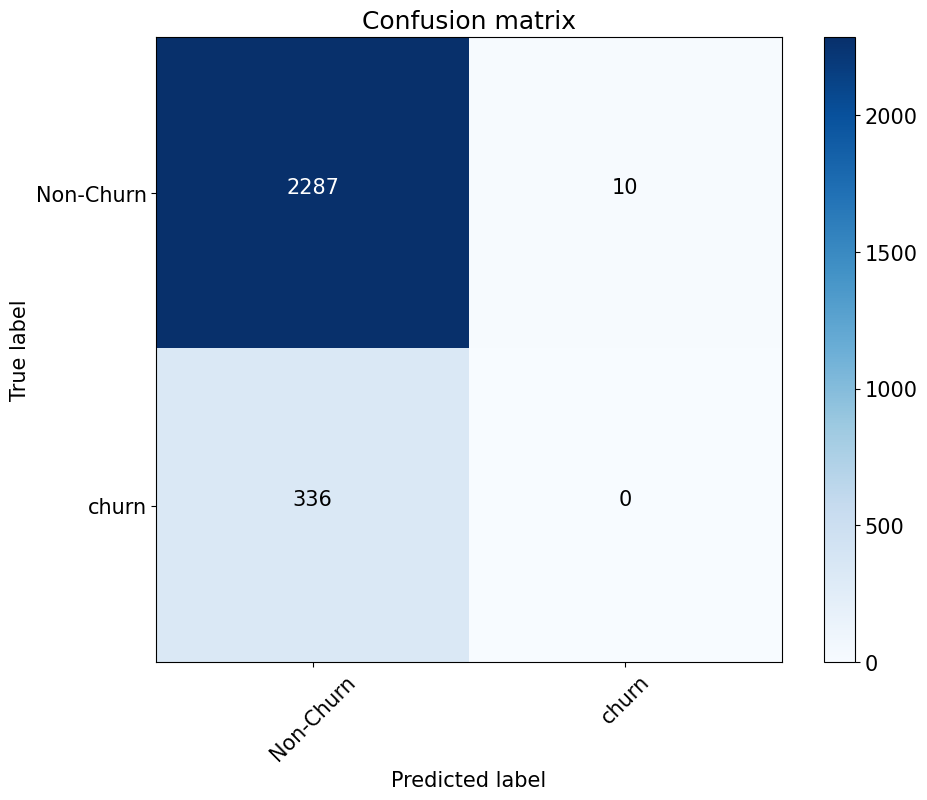

roc_auc_score = 0.5457208677985779


In [389]:
prf_idf = PRF_score(model_idf, test_X=test_X, test_Y=test_Y)
prf_idf.start()